# Ranking

Second Assignement of Learning with Massive Data. 


Pah of documents and queries

In [1]:
path_name_documents = './Databases/prova/prova.jsonl'
path_name_query = './Databases/prova/queries.jsonl'

#path_name_documents = './Databases/trec-covid/corpus.jsonl'
#path_name_query = './Databases/trec-covid/queries.jsonl'

#path_name_documents = './Databases/scidocs/corpus.jsonl'
#path_name_query = './Databases/scidocs/queries.jsonl'

# Usefull Functions

In [2]:
import pandas as pd

def score_table(score):
    df = pd.DataFrame(score)

    df.index = ["Query " + str(i+1) for i in range(len(df.index))]    #i+1
    df.columns = ["Document " + str(i+1) for i in range(len(df.columns))]

    return df


def printDocsQuery(documents,queries,results_k,list_top_k):  
    for query in queries:   
        print("QUERY: "+ query[1])
        print()
        elem = int(query[0])-1
        doc = [a for a, b in list_top_k[elem]]
        for position in doc:
            #print(documents[position][0])
            print(position)
            print()
    



# Read Files

In [3]:
import json
import numpy as np
import string

def readFile(path_name):
    # Load the JSONL file into a list
    with open(path_name, 'r') as f:
        lines = f.readlines()

    # Convert each JSON object into a dictionary
    dicts = [json.loads(line) for line in lines]

    # Convert the dictionaries into arrays and stack them vertically
    arrays = np.vstack([np.array(list(d.values())) for d in dicts])

    # Convert the arrays into a list of lists
    text = arrays.tolist()
    
    return text

documents = readFile(path_name_documents)
queries = readFile(path_name_query)


# Tokenize, Stemming and Lemming

In [4]:
import json
import nltk
import re
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer


stop_words = set(stopwords.words('english'))

def stemmingLemming(filtered_tokens):
    stemmer = PorterStemmer()
    lemmatizer = WordNetLemmatizer()

    # Perform stemming or lemmatization on filtered tokens
    
    filtered_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]
    filtered_tokens = [stemmer.stem(token) for token in filtered_tokens]

    return filtered_tokens
    
 
    

def tokenize(path_name):
    
    with open(path_name, "r") as f:
        data = f.readlines()

        # Create an empty list to store the tokenized documents
        tokenized_docs = []

        # Loop through each line in the JSONL file
        for line in data:
            # Parse the JSON string into a Python dictionary
            doc = json.loads(line)

            # Extract the text from the dictionary
            text = doc['text']
            text = text.lower()  # Convert to lowercase
            #text = re.sub(r'\d+', '', text)  # Remove all numbers
            text = text.translate(str.maketrans('', '', string.punctuation))  # Remove all punctuation

            # Tokenize the text using NLTK
            tokens = word_tokenize(text)
            tokensStemLem = stemmingLemming(tokens)

            # Add the tokenized document to the list
            tokenized_docs.append(tokensStemLem)

        # Print the tokenized documents
    return tokenized_docs


tokenized_docs = tokenize(path_name_documents)
tokenized_query = tokenize(path_name_query)




# Sparse Vectors



### TF-IDF 

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer


def calculateTFIDF(tokenized_docs):
    
    vectorizer = TfidfVectorizer()
    # Fit and transform the tokenized documents into a TF-IDF matrix
    tfidf_matrix = vectorizer.fit_transform([' '.join(doc) for doc in tokenized_docs])

    # Get the feature names (tokens)
    feature_names = vectorizer.get_feature_names_out()

    # Return the TF-IDF matrix and the feature names
    return tfidf_matrix, feature_names,vectorizer
    
    
def calculateTFIDFQuery(tokenized_query,vectorizer):
    
    # Transform the tokenized documents into a TF-IDF matrix
    tfidf_matrix = vectorizer.transform([' '.join(doc) for doc in tokenized_query])

    # Get the feature names (tokens)
    feature_names = vectorizer.get_feature_names_out()

    # Return the TF-IDF matrix and the feature names
    return tfidf_matrix, feature_names

    

tfidf_matrix_docs, feature_names_docs,vectorizer  = calculateTFIDF(tokenized_docs)
tfidf_matrix_query, feature_names_query  = calculateTFIDFQuery( tokenized_query,vectorizer)



### Dot Product for Sparse Vectors

In [6]:
import numpy as np


def calculate_Dot_Product_Sparse(tfidf_matrix_docs, tfidf_matrix_query):
    matrix_docs = tfidf_matrix_docs.toarray()
    matrix_query = tfidf_matrix_query.toarray()
    num_queries = matrix_query.shape[0]
    num_docs = matrix_docs.shape[0]
    sparse_score_results = []
    
    for query in range(num_queries):
        sparse_score_docs = []
        for doc in range(num_docs):
            dot_result = matrix_query[query].dot(matrix_docs[doc]) 
            sparse_score_docs.append(dot_result)
        sparse_score_results.append(sparse_score_docs)
        
    return sparse_score_results


sparse_score_results = calculate_Dot_Product_Sparse(tfidf_matrix_docs,tfidf_matrix_query)
sparse_score_table = score_table(sparse_score_results)
sparse_score_table


,Document 1,Document 2,Document 3,Document 4,Document 5,Document 6,Document 7,Document 8,Document 9,Document 10,...,Document 29990,Document 29991,Document 29992,Document 29993,Document 29994,Document 29995,Document 29996,Document 29997,Document 29998,Document 29999
Query 1,0.038540,0.096235,0.079767,0.039285,0.044150,0.047540,0.023852,0.072116,0.032240,0.046974,...,0.082468,0.050065,0.043111,0.074055,0.080316,0.076056,0.0,0.0,0.042226,0.032070
Query 2,0.038931,0.069832,0.079370,0.023099,0.089098,0.043150,0.101655,0.049865,0.062622,0.056058,...,0.078109,0.038283,0.039143,0.043220,0.029540,0.066495,0.0,0.0,0.062916,0.093580
Query 3,0.030138,0.007274,0.028779,0.031952,0.044926,0.002256,0.023794,0.005451,0.021267,0.000000,...,0.015753,0.009288,0.006272,0.018495,0.000000,0.007441,0.0,0.0,0.003447,0.062542
Query 4,0.009522,0.000000,0.004927,0.000000,0.023504,0.014749,0.000000,0.000000,0.004779,0.011605,...,0.032926,0.000000,0.000000,0.011459,0.000000,0.000000,0.0,0.0,0.000000,0.014261
Query 5,0.005596,0.022741,0.018196,0.037114,0.009617,0.008908,0.026530,0.006981,0.021851,0.016354,...,0.011227,0.010156,0.035522,0.031678,0.007743,0.019069,0.0,0.0,0.019370,0.008382
Query 6,0.016087,0.045159,0.031391,0.026235,0.019588,0.016613,0.020313,0.025597,0.018565,0.028996,...,0.029472,0.026770,0.030605,0.057052,0.026521,0.040059,0.0,0.0,0.006744,0.010244
Query 7,0.011479,0.032316,0.032668,0.013369,0.049204,0.024123,0.043955,0.007272,0.013234,0.036942,...,0.003022,0.017783,0.019197,0.036624,0.006948,0.006555,0.0,0.0,0.019454,0.021215
Query 8,0.031357,0.085085,0.061647,0.032494,0.048131,0.033676,0.033647,0.051645,0.036507,0.037590,...,0.040767,0.044397,0.035306,0.066966,0.082282,0.058273,0.0,0.0,0.024236,0.046669
Query 9,0.013692,0.000000,0.000000,0.014028,0.000000,0.000000,0.000000,0.000000,0.000000,0.014911,...,0.000000,0.003715,0.011252,0.000000,0.011284,0.000000,0.0,0.0,0.000000,0.041652
Query 10,0.066742,0.070031,0.042089,0.033190,0.028921,0.034757,0.011363,0.048984,0.030259,0.045538,...,0.062441,0.041800,0.028815,0.044576,0.034464,0.049822,0.0,0.0,0.026552,0.029403


# Dense Vector

In [7]:
from sentence_transformers import SentenceTransformer

def create_dense_vector(document):
    # Load the all-MiniLM-L6-v2 model
    model = SentenceTransformer('all-MiniLM-L6-v2')
    
    # Create a dense vector representation of the document
    dense_vector = model.encode(document, convert_to_tensor=True)
        
    return dense_vector


dense_vector_document = create_dense_vector(documents)
dense_vector_query = create_dense_vector(queries)




### Dot Product for Dense Vector

In [8]:
def calculate_Dot_Product_Dense(dense_vector_document, dense_vector_query):
    num_queries = dense_vector_query.shape[0]
    num_docs = dense_vector_document.shape[0]
    dense_score_results = []
    
    for query in range(num_queries):
        dense_score_docs = []
        for doc in range(num_docs):
            dot_result = np.dot(dense_vector_query[query], dense_vector_document[doc]) #dense_vector_query[query].dot(dense_vector_document[doc])
            dense_score_docs.append(dot_result)
        dense_score_results.append(dense_score_docs)
        
    return dense_score_results


dense_score_results = calculate_Dot_Product_Dense(dense_vector_document, dense_vector_query)
dense_score_table = score_table(dense_score_results)
dense_score_table
    

,Document 1,Document 2,Document 3,Document 4,Document 5,Document 6,Document 7,Document 8,Document 9,Document 10,...,Document 29990,Document 29991,Document 29992,Document 29993,Document 29994,Document 29995,Document 29996,Document 29997,Document 29998,Document 29999
Query 1,0.133962,0.106983,0.226969,0.126819,0.324864,0.217792,0.038656,0.038245,0.077958,0.173893,...,0.118379,-0.006509,0.011185,0.014506,0.296537,0.292081,0.359211,0.366997,0.089618,0.192446
Query 2,0.066888,0.096966,0.279706,0.121130,0.310443,0.200889,0.052010,0.070468,0.099589,0.161712,...,0.098519,-0.043537,-0.020484,-0.101310,0.223871,0.203476,0.374564,0.361167,0.139065,0.099568
Query 3,0.194563,0.120762,0.322730,0.129222,0.261768,0.200194,0.167548,0.103854,0.115690,0.136200,...,0.084694,0.061325,0.077967,0.008170,0.241163,0.198572,0.515745,0.304234,0.175759,0.372062
Query 4,0.131543,0.226517,0.249557,0.214995,0.339539,0.206882,0.168591,0.175452,0.144724,0.111294,...,0.158104,0.096986,0.098727,0.024453,0.207081,0.182138,0.384664,0.384391,0.100043,0.255768
Query 5,0.095667,0.222562,0.330017,0.203857,0.242839,0.142185,0.110872,0.190014,0.229337,0.148948,...,0.045433,0.097524,0.081592,0.052271,0.271307,0.259378,0.366146,0.239230,0.198632,0.254144
Query 6,0.173545,0.096595,0.171428,0.057788,0.219801,0.182564,0.211420,0.147272,0.092435,0.271069,...,0.050584,0.022828,0.080383,0.123016,0.223065,0.179078,0.342550,0.352206,0.183050,0.198529
Query 7,0.213392,0.104680,0.231447,0.153244,0.285167,0.150482,0.233630,0.177980,0.174007,0.183099,...,0.132502,0.117602,0.092311,0.177309,0.229630,0.253418,0.280411,0.437346,0.174139,0.206743
Query 8,0.152630,0.118768,0.170204,0.102133,0.181831,0.162573,0.278159,0.135007,0.129492,0.202244,...,0.064254,0.044323,0.167155,0.182287,0.161534,0.119381,0.394901,0.406470,0.132995,0.191222
Query 9,0.066558,0.064783,0.082429,0.083235,0.219832,0.130397,0.147970,0.148426,0.025930,0.148640,...,0.071852,-0.028083,0.085854,0.030167,0.144005,0.151500,0.320288,0.408874,0.099797,0.169535
Query 10,0.082550,0.118295,0.100848,0.094167,0.132487,0.084940,0.176099,0.119457,0.024127,0.221782,...,-0.029585,-0.025935,0.045578,0.039364,0.136644,0.137291,0.343353,0.451975,0.068106,0.220689


# Calculate the final score for each query

In [9]:
import numpy as np


def calculate_full_score(sparse_score_results,dense_score_results):
    sparse_vector = np.stack(sparse_score_results)
    dense_vector = np.stack(dense_score_results)
    full_vector = sparse_vector + dense_vector
    
    return full_vector, dense_vector,sparse_vector
    
full_vector, dense_vector,sparse_vector = calculate_full_score(sparse_score_results,dense_score_results)

df = score_table(full_vector)
df

,Document 1,Document 2,Document 3,Document 4,Document 5,Document 6,Document 7,Document 8,Document 9,Document 10,...,Document 29990,Document 29991,Document 29992,Document 29993,Document 29994,Document 29995,Document 29996,Document 29997,Document 29998,Document 29999
Query 1,0.172503,0.203218,0.306737,0.166103,0.369014,0.265332,0.062508,0.110361,0.110198,0.220867,...,0.200847,0.043556,0.054296,0.088561,0.376853,0.368137,0.359211,0.366997,0.131844,0.224516
Query 2,0.105819,0.166797,0.359076,0.144230,0.399541,0.244039,0.153666,0.120334,0.162211,0.217770,...,0.176628,-0.005253,0.018659,-0.058090,0.253412,0.269971,0.374564,0.361167,0.201981,0.193147
Query 3,0.224702,0.128035,0.351509,0.161174,0.306694,0.202450,0.191342,0.109305,0.136956,0.136200,...,0.100447,0.070612,0.084239,0.026665,0.241163,0.206013,0.515745,0.304234,0.179206,0.434604
Query 4,0.141064,0.226517,0.254484,0.214995,0.363043,0.221631,0.168591,0.175452,0.149503,0.122899,...,0.191030,0.096986,0.098727,0.035912,0.207081,0.182138,0.384664,0.384391,0.100043,0.270030
Query 5,0.101263,0.245303,0.348213,0.240972,0.252455,0.151093,0.137402,0.196995,0.251188,0.165302,...,0.056659,0.107680,0.117115,0.083949,0.279050,0.278447,0.366146,0.239230,0.218001,0.262527
Query 6,0.189632,0.141755,0.202819,0.084023,0.239389,0.199177,0.231732,0.172868,0.111000,0.300066,...,0.080056,0.049598,0.110988,0.180068,0.249586,0.219137,0.342550,0.352206,0.189795,0.208773
Query 7,0.224872,0.136996,0.264115,0.166613,0.334371,0.174605,0.277585,0.185252,0.187241,0.220041,...,0.135524,0.135385,0.111508,0.213934,0.236578,0.259973,0.280411,0.437346,0.193593,0.227957
Query 8,0.183988,0.203853,0.231852,0.134626,0.229962,0.196249,0.311805,0.186652,0.165998,0.239834,...,0.105021,0.088720,0.202461,0.249253,0.243816,0.177654,0.394901,0.406470,0.157231,0.237891
Query 9,0.080249,0.064783,0.082429,0.097263,0.219832,0.130397,0.147970,0.148426,0.025930,0.163551,...,0.071852,-0.024368,0.097106,0.030167,0.155289,0.151500,0.320288,0.408874,0.099797,0.211187
Query 10,0.149292,0.188326,0.142937,0.127356,0.161409,0.119698,0.187462,0.168441,0.054386,0.267320,...,0.032856,0.015865,0.074393,0.083941,0.171108,0.187113,0.343353,0.451975,0.094658,0.250092


# Choose parameters

## Select query

Initialize the vector for the specific query choosen

In [10]:
def initialize_vectors(n_query):
    score_sparse = sparse_vector [n_query]
    score_dense = dense_vector [n_query]
    score_full = full_vector [n_query]
    
    return score_sparse, score_dense, score_full


In [11]:
#take the position of top k score
def ground_truth_tok_k(K,score_full):
    ground_truth = np.argsort(score_full)[::-1][:K]
    
    return ground_truth 


### For sparse and dense vector we take the best k_p elements

In [12]:
def best_top_k_first(K_p,score_dense,score_sparse):
    best_dense = np.argsort(score_dense)[::-1][:K_p]
    best_sparse = np.argsort(score_sparse)[::-1][:K_p]
    
    return best_sparse, best_dense


### Union, without duplicate, of best sparse and best dense elements of vectors

In [13]:
def union_best_vectors(best_sparse, best_dense):
    best_index_score = list(set(list(best_sparse) + list(best_dense))) #union
    return best_index_score


### Take the best score from the final score list using the indexes of sparse and dense union list and also return the best indexes sorted

In [14]:
def sort_lists(listA, listB):
    listC = [0] * len(listA)
    for i in range(len(listB)):
        listC[i] = listA[listB[i]]
    return listC


In [15]:
def best_full_score_function(best_index_score,score_full):
    best_full_score = score_full[best_index_score]
    order_best_full_score = np.argsort(best_full_score)[::-1]  
    order_best_full_score = sort_lists(best_index_score,order_best_full_score)
    
    return best_full_score, order_best_full_score


## Create a list with the indexes of best score ordered and take the first K.

In [16]:
def retrieved_K_indexes(order_best_full_score,K):
    actual_order = list(order_best_full_score)
    k_indexes_ordered = actual_order[:K]
    
    return k_indexes_ordered


In [17]:
def calculate_relevant_docs(k_indexes_ordered,ground_truth):
    relevant = set(k_indexes_ordered).intersection(ground_truth)
    real_relevant_docs =len(relevant)/len(ground_truth)
    return real_relevant_docs
   

### Problem execution function

In [64]:
def execution(K, full_vector, dense_vector,sparse_vector):
    number_query = full_vector.shape[0]
    number_documents = full_vector.shape[1]
    results = []

    for query in range(0, number_query):
        for k_first in range(K, number_documents):
            
            score_sparse, score_dense,score_full = initialize_vectors(query)

            ground_truth = ground_truth_tok_k(K,score_full)

            best_sparse, best_dense = best_top_k_first(k_first,score_dense,score_sparse)  

            best_index_score = union_best_vectors(best_sparse, best_dense)

            best_full_score, order_best_full_score = best_full_score_function(best_index_score,score_full)

            k_indexes_ordered = retrieved_K_indexes(order_best_full_score, K)

            real_relevant_docs = calculate_relevant_docs(k_indexes_ordered,ground_truth)
            results.append((k_first, real_relevant_docs))
            
    return results
       
results = execution(2000, full_vector, dense_vector,sparse_vector)


### For each query, we compute recall as k_first varies. Then we average all the results

In [65]:
def divide_results_by_k_first(results): 
    divided_results = {} 
    for result in results: 
        k_first = result[0] 
        real_relevant_docs = result[1] 
        if k_first not in divided_results: 
            divided_results[k_first] = [] 
        divided_results[k_first].append(real_relevant_docs) 
    return divided_results


In [66]:
def calculate_average_results(results):
    divided_results = divide_results_by_k_first(results)
    average_results = []
    for k_first, relevant_docs_list in divided_results.items():
        average = sum(relevant_docs_list) / len(relevant_docs_list)
        average_results.append((k_first, average))
    return average_results


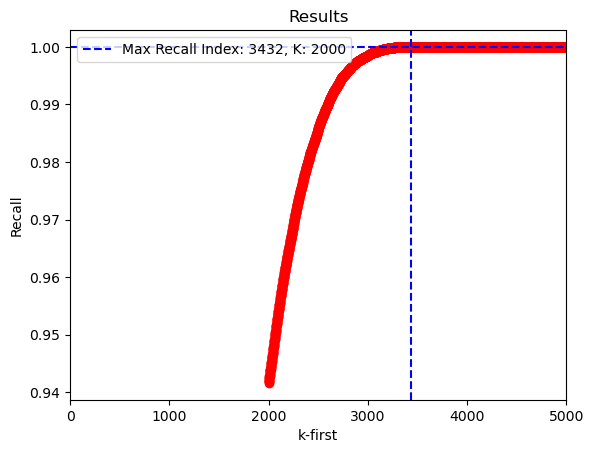

In [69]:
import matplotlib.pyplot as plt

def plot_results(results):
    average_results = calculate_average_results(results)
    number_k = average_results[0][0]
    x = [k_first for k_first, average in average_results]
    y = [average for k_first, average in average_results]
    plt.plot(x, y, 'ro')
    plt.xlabel('k-first')
    plt.ylabel('Recall')
    plt.title('Results')
    
    max_recall_index = y.index(1.0)
    max_recall_k_first = x[max_recall_index]
    plt.axvline(x=x[max_recall_index], linestyle='--', color='blue', label=f'Max Recall Index: {max_recall_k_first}, K: {number_k}')
    plt.legend()
    
    for i, (k_first, recall) in enumerate(average_results):
        if recall == 1.0:
            plt.axhline(y=recall, xmin=0, xmax=k_first, linestyle='--', color='blue')
            break
    
    plt.xlim(left=0,right=5000)
    plt.show(max_recall_k_first)
 
    
graph = plot_results(results)
graph